In [1]:
import pandas as pd
import os.path as osp
import os
import statistics
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import re

get a table where the column names are the different KG settings

and the rows are the different approaches

and the values are MRR

In [19]:
OUTPUT_DIR = '../data/output/ICLR_results'

In [5]:
test_results = pd.read_csv('/home/lauren/neurosymbolic-mechanism/data/output/ICLR_results/MoA-net (no inverse edges)/naive_updates/experiment_metrics.tsv',  sep='\t', index_col=0)

In [16]:
test_results.columns

Index([' metrics', ' metrics (pruned)'], dtype='object')

In [17]:
test_results.at['MRR', ' metrics']

'(0.086, 0.021)'

In [31]:
approach_name_map = {'PoLo': 'PoLo',
                       'naive_updates': 'MARS, naive updates',
                       'p2h_updates': 'MARS, P2H updates'}

In [32]:
mrr_dict = dict()

# iterate through subdirectories
for exp_name in os.listdir(OUTPUT_DIR):
    experiment = osp.join(OUTPUT_DIR, exp_name)
    if not osp.isdir(experiment):
        continue
    mrr_dict[exp_name] = dict()
    for approach in os.listdir(experiment):
        approach_dir = osp.join(experiment, approach)
        if not osp.isdir(approach_dir):
            continue
        approach_metrics_file = osp.join(approach_dir, 'experiment_metrics.tsv')
        approach_metrics = pd.read_csv(approach_metrics_file, sep='\t', index_col=0)
        # get the row with index MRR
        mrr_dict[exp_name][approach_name_map[approach]] = approach_metrics.at['MRR', ' metrics']
        mrr_dict[exp_name][approach_name_map[approach] + ' (pruned)'] = approach_metrics.at['MRR', ' metrics (pruned)']


In [33]:
mrr_table = pd.DataFrame(mrr_dict)

In [38]:
mrr_table = mrr_table[['MoA-net (no inverse edges)',
                       'MoA-net-10k (no inverse edges)',
                       'MoA-net-10k (with inverse edges)']]

In [39]:
# For every column remove the parentheses, and split by comma getting the first element
table2_values = mrr_table.applymap(lambda x: x.split(",")[0].replace("(", ""))

table2_sd = mrr_table.applymap(lambda x: x.split(",")[1].replace(")", ""))

# to numeric
table2_values = table2_values.apply(pd.to_numeric)
table2_sd = table2_sd.apply(pd.to_numeric)

In [40]:
new_order = [
    "PoLo",
    "MARS, naive updates",
    "MARS, P2H updates",
    "PoLo (pruned)",
    "MARS, naive updates (pruned)",
    "MARS, P2H updates (pruned)" 
]
table2_values = table2_values.reindex(index=new_order)
table2_sd = table2_sd.reindex(index=new_order)

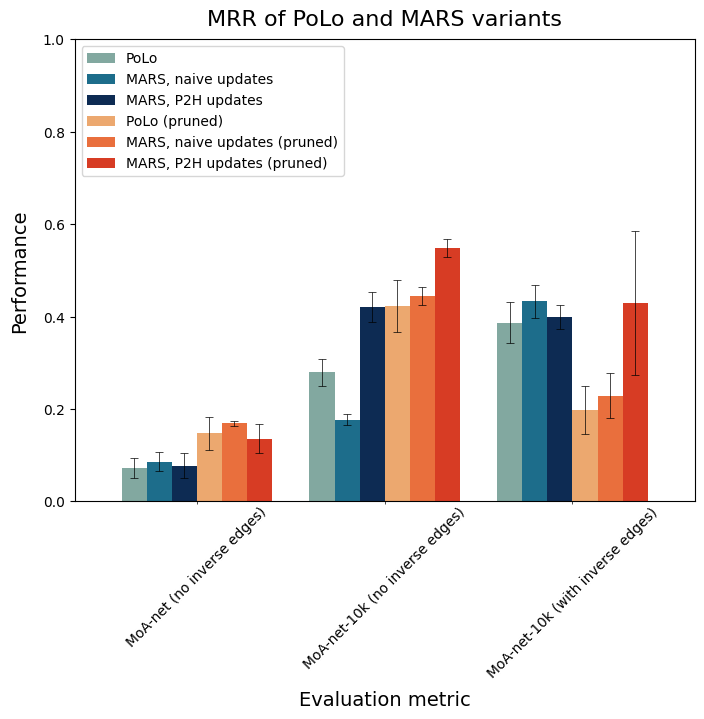

In [43]:
color_dict = {
    "PoLo": "#82a8a0",
    "PoLo (pruned)": "#eca86f",
    "MARS, P2H updates (pruned)": "#d73c24",
    "MARS, naive updates": "#1d6d8b",
    "MARS, naive updates (pruned)": "#e96f3d",
    "MARS, P2H updates": "#0d2b53",
}

table2_values.T.plot.bar(
    color=color_dict,
    yerr=table2_sd.T,
    capsize=4,
    ecolor="black",
    error_kw=dict(lw=0.5, capsize=3, capthick=0.5),
    # make bars thicker
    width=0.8,
)

# Move legend out
plt.legend(loc="upper left")
# Title legend
plt.title(
    "MRR of PoLo and MARS variants",
    pad=10,
    fontsize=16,
)

# Y label empty
plt.ylabel("Performance", labelpad=10, fontsize=14)
# Y label 0-1
plt.ylim(0, 1)

# x labels rotation
plt.xticks(rotation=45)

# make bars thicker and reduce the space between ticks
plt.tick_params(axis="x", width=0.5, length=2, pad=0.5)

# X label
plt.xlabel("Evaluation metric", labelpad=7, fontsize=14)

# make the plot wider
plt.gcf().set_size_inches(8, 6)

# legend position down
#plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)

plt.savefig(
    osp.join(OUTPUT_DIR, "evaluation_metrics.png"), dpi=400, bbox_inches="tight"
)

plt.show()